# Week 5: Model Development & Training

This notebook covers:
1. Baseline model development
2. Decision Tree implementation
3. Random Forest training
4. XGBoost implementation
5. Model evaluation and comparison

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import xgboost as xgb

# Set up paths
DATA_PROCESSED = Path('../data/processed')
MODELS = Path('../models')
REPORTS = Path('../reports/figures')

print("✅ Libraries imported and paths set up")

✅ Libraries imported and paths set up


In [3]:
# Load preprocessed datasets
print("📊 Loading preprocessed datasets...")

# Load scaled dataset (best for most ML algorithms)
X_train = pd.read_csv(DATA_PROCESSED / 'scaled' / 'X_train.csv', index_col=0)
X_test = pd.read_csv(DATA_PROCESSED / 'scaled' / 'X_test.csv', index_col=0)
y_train = pd.read_csv(DATA_PROCESSED / 'scaled' / 'y_train.csv', index_col=0).squeeze()
y_test = pd.read_csv(DATA_PROCESSED / 'scaled' / 'y_test.csv', index_col=0).squeeze()

print(f"✅ Training set: {X_train.shape}")
print(f"✅ Test set: {X_test.shape}")
print(f"✅ Features: {list(X_train.columns)}")
print(f"✅ Target distribution - Train: {y_train.value_counts().to_dict()}")
print(f"✅ Target distribution - Test: {y_test.value_counts().to_dict()}")

# Display first few rows
print("\n🔍 Training data preview:")
X_train.head()

📊 Loading preprocessed datasets...
✅ Training set: (32, 9)
✅ Test set: (8, 9)
✅ Features: ['toxicity_score', 'category_encoded', 'health_impact_encoded', 'allergen_risk_encoded', 'risk_level_encoded', 'toxicity_level', 'high_toxicity_flag', 'toxicity_score_squared', 'toxicity_score_normalized']
✅ Target distribution - Train: {0: 22, 1: 10}
✅ Target distribution - Test: {0: 5, 1: 3}

🔍 Training data preview:


,toxicity_score,category_encoded,health_impact_encoded,allergen_risk_encoded,risk_level_encoded,toxicity_level,high_toxicity_flag,toxicity_score_squared,toxicity_score_normalized
10,0.777151,0.837042,0.361544,0.356034,0.020984,0.471405,-0.577350,0.527841,0.777151
35,-1.206254,-1.361755,-1.147509,-1.542816,1.363970,-0.471405,-0.577350,-0.876273,-1.206254
13,0.319443,1.036933,0.361544,-3.441667,0.020984,0.471405,-0.577350,-0.045436,0.319443
1,1.540000,0.837042,0.864562,0.356034,-1.322002,1.414214,1.732051,1.815637,1.540000
37,-1.206254,-1.561646,-1.147509,0.356034,1.363970,-0.471405,-0.577350,-0.876273,-1.206254


In [4]:
# Model 1: Baseline Logistic Regression
print("🎯 MODEL 1: BASELINE LOGISTIC REGRESSION")
print("=" * 50)

# Train baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
baseline_pred = baseline_model.predict(X_test)
baseline_prob = baseline_model.predict_proba(X_test)[:, 1]

# Evaluation
baseline_metrics = {
    'accuracy': accuracy_score(y_test, baseline_pred),
    'precision': precision_score(y_test, baseline_pred),
    'recall': recall_score(y_test, baseline_pred),
    'f1_score': f1_score(y_test, baseline_pred),
    'roc_auc': roc_auc_score(y_test, baseline_prob)
}

print("📊 Baseline Model Results:")
for metric, value in baseline_metrics.items():
    print(f"  {metric.capitalize()}: {value:.3f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, baseline_pred))

# Cross-validation
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n🔄 Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Save model
joblib.dump(baseline_model, MODELS / 'baseline_logistic_regression.pkl')
print("✅ Baseline model saved")

🎯 MODEL 1: BASELINE LOGISTIC REGRESSION
📊 Baseline Model Results:
  Accuracy: 0.750
  Precision: 1.000
  Recall: 0.333
  F1_score: 0.500
  Roc_auc: 1.000

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.33      0.50         3

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8


🔄 Cross-validation accuracy: 0.971 (+/- 0.114)
✅ Baseline model saved


In [5]:
# Model 2: Decision Tree
print("🌳 MODEL 2: DECISION TREE CLASSIFIER")
print("=" * 45)

# Hyperparameter tuning for Decision Tree
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

print("🔍 Performing hyperparameter tuning...")
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

print(f"✅ Best parameters: {dt_grid.best_params_}")
print(f"✅ Best CV score: {dt_grid.best_score_:.3f}")

# Predictions
dt_pred = best_dt.predict(X_test)
dt_prob = best_dt.predict_proba(X_test)[:, 1]

# Evaluation
dt_metrics = {
    'accuracy': accuracy_score(y_test, dt_pred),
    'precision': precision_score(y_test, dt_pred),
    'recall': recall_score(y_test, dt_pred),
    'f1_score': f1_score(y_test, dt_pred),
    'roc_auc': roc_auc_score(y_test, dt_prob)
}

print("\n📊 Decision Tree Results:")
for metric, value in dt_metrics.items():
    print(f"  {metric.capitalize()}: {value:.3f}")

# Feature importance
feature_importance_dt = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Feature Importance (Decision Tree):")
print(feature_importance_dt)

# Save model
joblib.dump(best_dt, MODELS / 'decision_tree_classifier.pkl')
print("\n✅ Decision Tree model saved")

🌳 MODEL 2: DECISION TREE CLASSIFIER
🔍 Performing hyperparameter tuning...
✅ Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
✅ Best CV score: 1.000

📊 Decision Tree Results:
  Accuracy: 0.875
  Precision: 1.000
  Recall: 0.667
  F1_score: 0.800
  Roc_auc: 0.833

🎯 Feature Importance (Decision Tree):
                     feature  importance
7     toxicity_score_squared         1.0
0             toxicity_score         0.0
1           category_encoded         0.0
2      health_impact_encoded         0.0
3      allergen_risk_encoded         0.0
4         risk_level_encoded         0.0
5             toxicity_level         0.0
6         high_toxicity_flag         0.0
8  toxicity_score_normalized         0.0

✅ Decision Tree model saved


In [6]:
# Model 3: Random Forest
print("🌲 MODEL 3: RANDOM FOREST CLASSIFIER")
print("=" * 45)

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("🔍 Performing hyperparameter tuning...")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print(f"✅ Best parameters: {rf_grid.best_params_}")
print(f"✅ Best CV score: {rf_grid.best_score_:.3f}")

# Predictions
rf_pred = best_rf.predict(X_test)
rf_prob = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
rf_metrics = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1_score': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_prob)
}

print("\n📊 Random Forest Results:")
for metric, value in rf_metrics.items():
    print(f"  {metric.capitalize()}: {value:.3f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Feature Importance (Random Forest):")
print(feature_importance_rf)

# Save model
joblib.dump(best_rf, MODELS / 'random_forest_classifier.pkl')
print("\n✅ Random Forest model saved")

🌲 MODEL 3: RANDOM FOREST CLASSIFIER
🔍 Performing hyperparameter tuning...
✅ Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best CV score: 1.000

📊 Random Forest Results:
  Accuracy: 0.875
  Precision: 1.000
  Recall: 0.667
  F1_score: 0.800
  Roc_auc: 0.833

🎯 Feature Importance (Random Forest):
                     feature  importance
7     toxicity_score_squared    0.334531
0             toxicity_score    0.267158
8  toxicity_score_normalized    0.163095
4         risk_level_encoded    0.096146
6         high_toxicity_flag    0.070747
5             toxicity_level    0.067756
1           category_encoded    0.000567
2      health_impact_encoded    0.000000
3      allergen_risk_encoded    0.000000

✅ Random Forest model saved


In [7]:
# Model 4: XGBoost
print("🚀 MODEL 4: XGBOOST CLASSIFIER")
print("=" * 40)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0]
}

print("🔍 Performing hyperparameter tuning...")
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print(f"✅ Best parameters: {xgb_grid.best_params_}")
print(f"✅ Best CV score: {xgb_grid.best_score_:.3f}")

# Predictions
xgb_pred = best_xgb.predict(X_test)
xgb_prob = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation
xgb_metrics = {
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1_score': f1_score(y_test, xgb_pred),
    'roc_auc': roc_auc_score(y_test, xgb_prob)
}

print("\n📊 XGBoost Results:")
for metric, value in xgb_metrics.items():
    print(f"  {metric.capitalize()}: {value:.3f}")

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Feature Importance (XGBoost):")
print(feature_importance_xgb)

# Save model
joblib.dump(best_xgb, MODELS / 'xgboost_classifier.pkl')
print("\n✅ XGBoost model saved")

🚀 MODEL 4: XGBOOST CLASSIFIER
🔍 Performing hyperparameter tuning...
✅ Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
✅ Best CV score: 1.000

📊 XGBoost Results:
  Accuracy: 0.875
  Precision: 1.000
  Recall: 0.667
  F1_score: 0.800
  Roc_auc: 0.833

🎯 Feature Importance (XGBoost):
                     feature  importance
0             toxicity_score         1.0
1           category_encoded         0.0
2      health_impact_encoded         0.0
3      allergen_risk_encoded         0.0
4         risk_level_encoded         0.0
5             toxicity_level         0.0
6         high_toxicity_flag         0.0
7     toxicity_score_squared         0.0
8  toxicity_score_normalized         0.0

✅ XGBoost model saved


In [8]:
# Model comparison
print("📊 MODEL COMPARISON")
print("=" * 30)

# Compile all results
all_metrics = {
    'Logistic Regression': baseline_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics).T
comparison_df = comparison_df.round(3)

print("\n📋 Performance Comparison:")
print(comparison_df)

# Find best model for each metric
print("\n🏆 Best Models by Metric:")
for metric in comparison_df.columns:
    best_model = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    print(f"  {metric.capitalize()}: {best_model} ({best_score:.3f})")

# Overall best model (by F1-score)
best_overall = comparison_df['f1_score'].idxmax()
print(f"\n🎯 Overall Best Model: {best_overall} (F1-Score: {comparison_df.loc[best_overall, 'f1_score']:.3f})")

# Save comparison results
comparison_df.to_csv(REPORTS.parent / 'model_comparison_results.csv')
print("\n💾 Comparison results saved")

📊 MODEL COMPARISON

📋 Performance Comparison:
                     accuracy  precision  recall  f1_score  roc_auc
Logistic Regression     0.750        1.0   0.333       0.5    1.000
Decision Tree           0.875        1.0   0.667       0.8    0.833
Random Forest           0.875        1.0   0.667       0.8    0.833
XGBoost                 0.875        1.0   0.667       0.8    0.833

🏆 Best Models by Metric:
  Accuracy: Decision Tree (0.875)
  Precision: Logistic Regression (1.000)
  Recall: Decision Tree (0.667)
  F1_score: Decision Tree (0.800)
  Roc_auc: Logistic Regression (1.000)

🎯 Overall Best Model: Decision Tree (F1-Score: 0.800)

💾 Comparison results saved


📊 Creating visualizations...


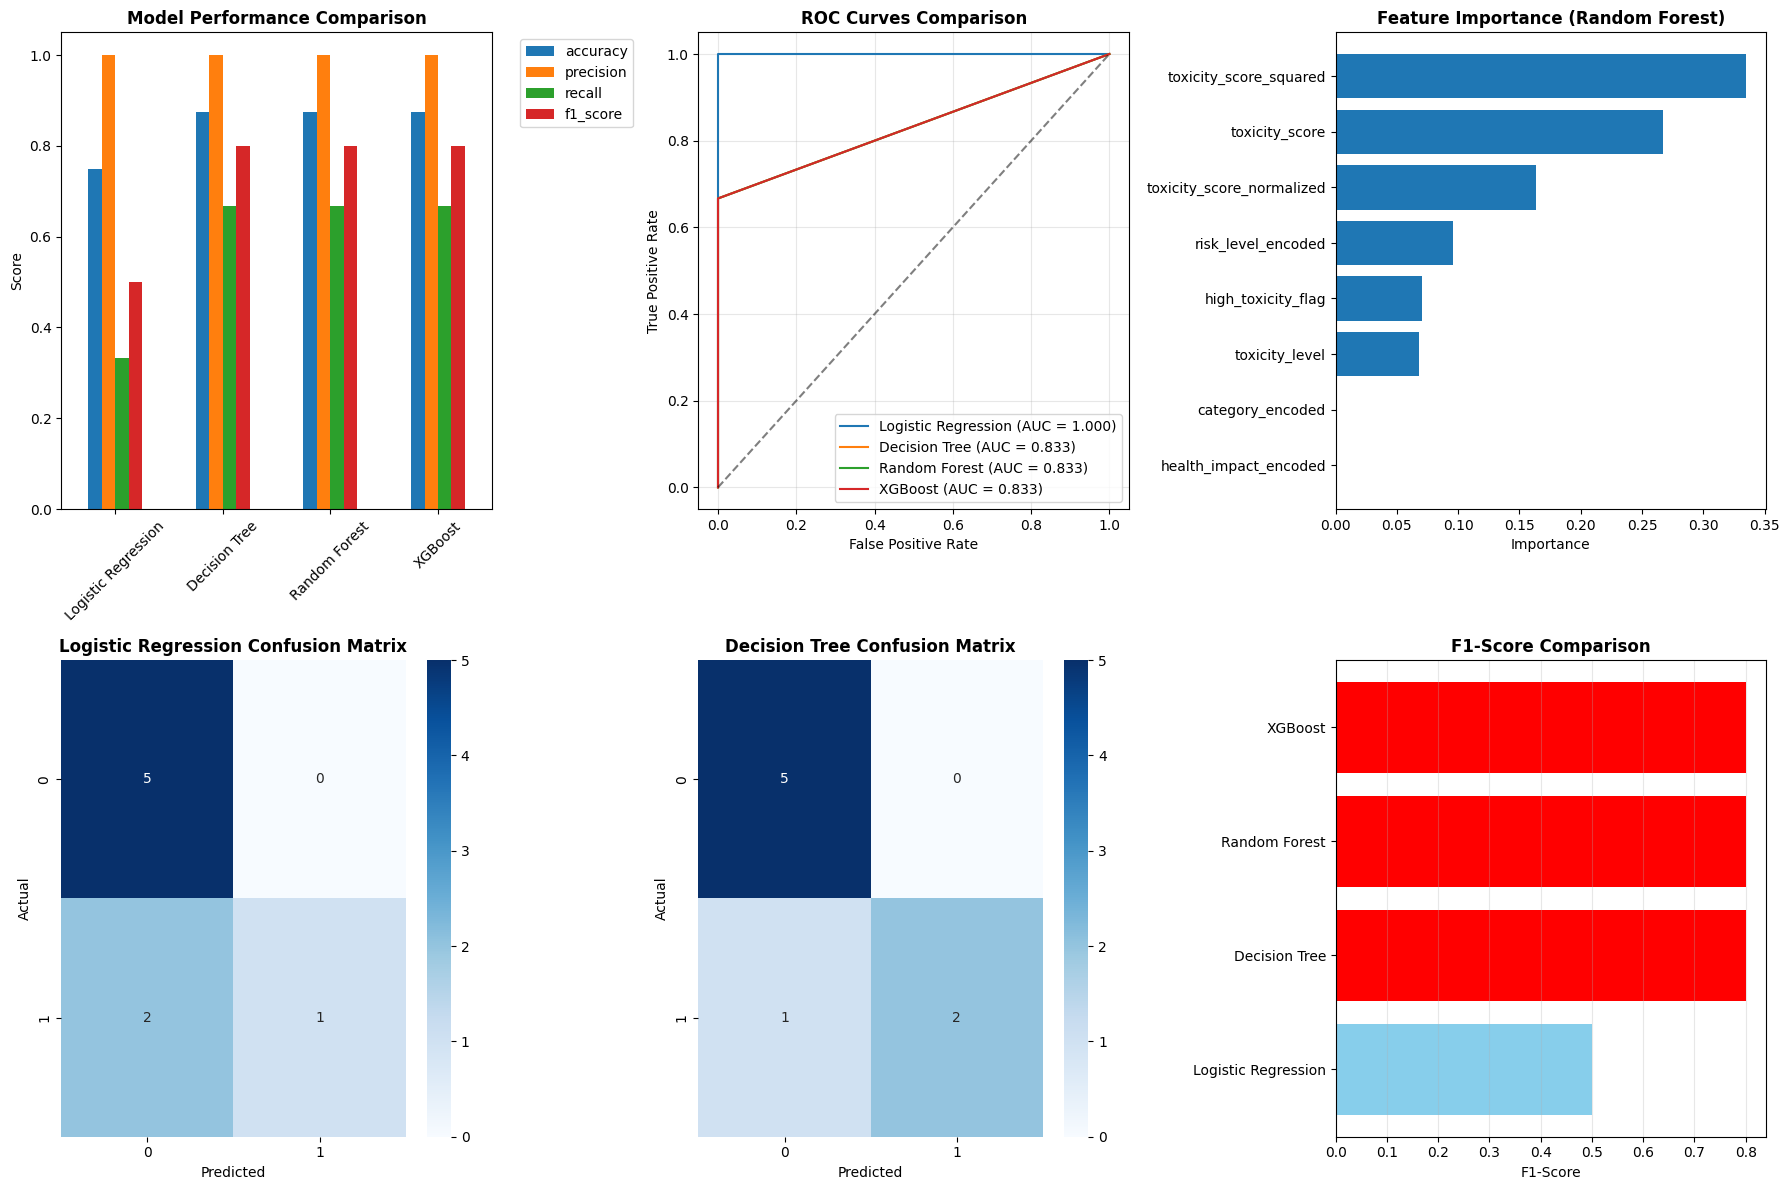

✅ Visualizations created and saved


In [9]:
# Visualizations
print("📊 Creating visualizations...")

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model Performance Comparison
ax1 = axes[0, 0]
comparison_df[['accuracy', 'precision', 'recall', 'f1_score']].plot(kind='bar', ax=ax1)
ax1.set_title('Model Performance Comparison', fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. ROC Curves
ax2 = axes[0, 1]
models_data = [
    ('Logistic Regression', baseline_prob),
    ('Decision Tree', dt_prob),
    ('Random Forest', rf_prob),
    ('XGBoost', xgb_prob)
]

for name, prob in models_data:
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc_score = roc_auc_score(y_test, prob)
    ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Importance (Random Forest)
ax3 = axes[0, 2]
top_features_rf = feature_importance_rf.head(8)
ax3.barh(range(len(top_features_rf)), top_features_rf['importance'])
ax3.set_yticks(range(len(top_features_rf)))
ax3.set_yticklabels(top_features_rf['feature'])
ax3.set_xlabel('Importance')
ax3.set_title('Feature Importance (Random Forest)', fontweight='bold')
ax3.invert_yaxis()

# 4. Confusion Matrices
models_pred = [
    ('Logistic Regression', baseline_pred),
    ('Decision Tree', dt_pred),
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred)
]

for i, (name, pred) in enumerate(models_pred[:2]):
    ax = axes[1, i]
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'{name} Confusion Matrix', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# 5. F1-Score Comparison
ax5 = axes[1, 2]
f1_scores = comparison_df['f1_score'].sort_values(ascending=True)
colors = ['red' if x == f1_scores.max() else 'skyblue' for x in f1_scores]
ax5.barh(range(len(f1_scores)), f1_scores.values, color=colors)
ax5.set_yticks(range(len(f1_scores)))
ax5.set_yticklabels(f1_scores.index)
ax5.set_xlabel('F1-Score')
ax5.set_title('F1-Score Comparison', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(REPORTS / 'model_comparison_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations created and saved")

In [10]:
# Model summary and recommendations
print("📋 MODEL DEVELOPMENT SUMMARY")
print("=" * 45)

# Create summary report
summary_report = {
    'Dataset Info': {
        'Training Samples': len(X_train),
        'Test Samples': len(X_test),
        'Features': len(X_train.columns),
        'Target Classes': len(y_train.unique())
    },
    'Models Trained': {
        'Baseline': 'Logistic Regression',
        'Tree-based': 'Decision Tree, Random Forest',
        'Boosting': 'XGBoost',
        'Total Models': 4
    },
    'Best Performance': {
        'Best Accuracy': f"{comparison_df['accuracy'].max():.3f} ({comparison_df['accuracy'].idxmax()})",
        'Best Precision': f"{comparison_df['precision'].max():.3f} ({comparison_df['precision'].idxmax()})",
        'Best Recall': f"{comparison_df['recall'].max():.3f} ({comparison_df['recall'].idxmax()})",
        'Best F1-Score': f"{comparison_df['f1_score'].max():.3f} ({comparison_df['f1_score'].idxmax()})",
        'Best ROC-AUC': f"{comparison_df['roc_auc'].max():.3f} ({comparison_df['roc_auc'].idxmax()})"
    },
    'Recommendations': {
        'Production Model': best_overall,
        'Reason': 'Highest F1-Score (balanced precision and recall)',
        'Alternative': comparison_df['accuracy'].idxmax() if comparison_df['accuracy'].idxmax() != best_overall else 'Random Forest'
    }
}

for section, info in summary_report.items():
    print(f"\n📊 {section}:")
    for key, value in info.items():
        print(f"  {key}: {value}")

# Save summary report
import json
with open(REPORTS.parent / 'model_development_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print("\n💾 Model development summary saved")
print("\n🎉 Week 5 Model Development Complete!")
print("\n📋 Next Steps (Week 6):")
print("  1. Ensemble model creation")
print("  2. Neural network implementation")
print("  3. Model optimization and fine-tuning")
print("  4. Final model selection and validation")

📋 MODEL DEVELOPMENT SUMMARY

📊 Dataset Info:
  Training Samples: 32
  Test Samples: 8
  Features: 9
  Target Classes: 2

📊 Models Trained:
  Baseline: Logistic Regression
  Tree-based: Decision Tree, Random Forest
  Boosting: XGBoost
  Total Models: 4

📊 Best Performance:
  Best Accuracy: 0.875 (Decision Tree)
  Best Precision: 1.000 (Logistic Regression)
  Best Recall: 0.667 (Decision Tree)
  Best F1-Score: 0.800 (Decision Tree)
  Best ROC-AUC: 1.000 (Logistic Regression)

📊 Recommendations:
  Production Model: Decision Tree
  Reason: Highest F1-Score (balanced precision and recall)
  Alternative: Random Forest

💾 Model development summary saved

🎉 Week 5 Model Development Complete!

📋 Next Steps (Week 6):
  1. Ensemble model creation
  2. Neural network implementation
  3. Model optimization and fine-tuning
  4. Final model selection and validation
